## Closest majors home team every year of Major League Baseball

### To send to NLBM contact page:
Hi NLBM!

I believe I might have the most complete database of Negro Leagues home stadiums anywhere, and would like to share some art I've made based on it that you might find relevant to Negro Leagues history.  The picture/video says more than I can in words, so send me an email and I'll shoot over a couple examples, since it can't be attached in this form!

The concept is to show which MLB home stadium is closest to everywhere in the continental US, of course including NNL I & II, NAL, ANL, ECL, EWL, and NSL.  I've made this map for every team and every year of the MLB based on detailed research, and think it is most impactful as an animation

# TODO:
- [ ] Stripes
- [ ] Recoloration process
- [ ] Rerun all with haversine
- [ ] Add dots in foreground for home stadium location
- [ ] Instead of showing dotmap, use it to find points of indifference and draw a line using GIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator
from math import radians, cos, sin, asin, sqrt
from colorama import Fore, Back, Style
import os
import glob
from PIL import Image # for gif
from datetime import datetime as dt

In [2]:
output_path = os.path.join(os.getcwd(), 'MLB gif')

In [3]:
valid_hex = '0123456789ABCDEF'.__contains__
def cleanhex(data):
    return ''.join(filter(valid_hex, data.upper()))

def fore_fromhex(text, hexcode):
    """print in a hex defined color"""
    hexint = int(cleanhex(hexcode), 16)
    
    if hexint >= 808080: # Bad way to do between white and black
        background = Back.BLACK
    else:
        background = Back.WHITE
        
    print(background
          + "\x1B[38;2;{};{};{}m{}\x1B[0m".format(hexint>>16
                                                  , hexint>>8&0xFF
                                                  , hexint&0xFF
                                                  , text)
         )

In [4]:
# Get points to check closest team
# http://download.geonames.org/export/dump/US.zip accessed on Oct 11 2021
us_coords = pd.read_csv('US_Coords\\US.txt'
                        , sep = '\t'
                        , names = [
                            'geonameid'
                            , 'name'
                            , 'asciiname'
                            , 'alternatenames'
                            , 'latitude'
                            , 'longitude'
                            , 'feature class'
                            , 'feature code'
                            , 'country code'
                            , 'cc2'
                            , 'admin1 code'
                            , 'admin2 code'
                            , 'admin3 code'
                            , 'admin4 code'
                            , 'population'
                            , 'elevation'
                            , 'dem'
                            , 'timezone'
                            , 'modification date'
                          ]
                       )

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Set up plot space
BBox = (-124.7844079, -66.9513812
        , 24.7433195, 49.3457868)

# Remove points outside the BBox.  Not going to see them anyways
df_points = us_coords[['latitude', 'longitude']].sample(frac = 1, random_state = 1)
df_points = df_points[
    (df_points['longitude'] >= BBox[0])
    & (df_points['longitude'] <= BBox[1])
    & (df_points['latitude'] >= BBox[2])
    & (df_points['latitude'] <= BBox[3])
]
# Sample for faster rendering
# frac = 1 means no sample, for better picture

In [6]:
# Chose to include all leagues recognized as major by today's MLB, however controersial
yr_to_league = {
    (1949, np.inf) : 'NL or AL'
    , (1937, 1948) : 'NL, AL, NNL, or NAL'
    , (1933, 1936) : 'NL, AL, or NNL'
    , (1932, 1932) : 'NL, AL, East-West League, or NSL'
    , (1930, 1931) : 'NL, AL, or NNL'
    , (1929, 1929) : 'NL, AL, NNL, or ANL'
    , (1923, 1928) : 'NL, AL, NNL, or ECL'
    , (1920, 1922) : 'NL, AL, or NNL'
    , (1916, 1919) : 'NL or AL'
    , (1914, 1915) : 'NL, AL, or FL'
    , (1901, 1913) : 'NL or AL'
    , (1892, 1900) : 'NL only'
    , (1891, 1891) : 'NL or AA'
    , (1890, 1890) : 'NL, AA, or PL'
    , (1885, 1889) : 'NL or AA'
    , (1884, 1884) : 'NL, AA, or UA'
    , (1882, 1883) : 'NL or AA'
    , (1876, 1881) : 'NL only'
    , (1871, 1875) : 'NA only'
}

In [7]:
# # Set up parameters for stripes
# stripes = [ # year start, year end, from color, to color
#       [1975, 1975,   '#0b2265', '#003f2d'] # ex New York: Giants to Jets
#     , [1984, np.inf, '#0b2265', '#003f2d'] # ex2
# ]

In [8]:
stripes = []

In [14]:
# All stadiums over time with lat/long, team, and start/end
stadia_header = ['coordinates', 'latitude', 'longitude', 'color', 'start', 'end']
stadia_alltime = [
    # https://en.wikipedia.org/wiki/List_of_current_Major_League_Baseball_stadiums
    # https://en.wikipedia.org/wiki/List_of_former_Major_League_Baseball_stadiums
    # https://www.baseball-reference.com/teams
    
    ## AL
    # Red Sox - Americans (AL)
      ['42°20′46.5″N 71°5′51.9″W', '#bd3039', 1912, np.inf, 'AL'] # Sunday games at nearby field ignored
    , ['42°20′20.3″N 71°5′20.3″W', '#bd3039', 1901, 1911, 'AL']
    # Yankees-Highlanders // 1901-02 Orioles considered a separate club
    , ['40°49′45″N 73°55′35″W', '#132448', 2009, np.inf, 'AL']
    , ['40°49′37″N 73°55′41″W', '#132448', 1976, 2008, 'AL']
    , ['40°45′20″N 73°50′53″W', '#132448', 1974, 1975, 'AL']
    , ['40°49′37″N 73°55′41″W', '#132448', 1923, 1973, 'AL']
    , ['40.8308, -73.9375', '#132448', 1913, 1922, 'AL'] # TODO: Stripes with Giants
    , ['40°50′26″N 73°56′32″W', '#132448', 1903, 1912, 'AL']
    # Orioles-Browns-Brewers
    , ['39°17′2″N 76°37′18″W', '#df4601', 1992, np.inf, 'AL'] #df4601 is orange
    , ['39°19′46″N 76°36′5″W', '#df4601', 1954, 1991, 'AL']
    , ['38.658, -90.220', '#df4601', 1902, 1953, 'AL']
    , ['43°3′32″N 87°56′2″W', '#ffc52f', 1901, 1901, 'AL']
    # Blue Jays // note multiple stadiums in 2021 and 1989
    , ['43°38′29″N 79°23′21″W', '#134a8e', 2021, np.inf, 'AL'] # 36 games in Toronto in 2021
    , ['28°0′13″N 82°47′11″W', '#134a8e', 2021, 2021, 'AL'] # 21 games in Tampa area
    , ['42°52′52.7″N 78°52′27.4″W', '#134a8e', 2020, 2021, 'AL'] # 22 games in Buffalo in 2021
    , ['43°38′29″N 79°23′21″W', '#134a8e', 1989, 2019, 'AL'] # One game in 2001 in San Juan ignored
    , ['43°37′55″N 79°25′4″W', '#134a8e', 1977, 1989, 'AL'] # 1989 is both Exhibition Stadium and Skydome
    # Rays - Devil Rays
    , ['27°46′6″N 82°39′12″W', '#8fbce6', 1998, np.inf, 'AL']
    # Guardians-Indians-Naps-Bronchos-Blues // Note sometimes dual stadiums
    , ['41°29′45″N 81°41′7″W', '#1a2e5a', 1994, np.inf, 'AL'] # 3 games in Milwaukee in 2008 ignored
    , ['41°30′24″N 81°41′50″W', '#1a2e5a', 1936, 1993, 'AL']
    , ['41°30′41″N 81°38′39″W', '#1a2e5a', 1934, 1946, 'AL']
    , ['41°30′24″N 81°41′50″W', '#1a2e5a', 1932, 1933, 'AL']
    , ['41°30′41″N 81°38′39″W', '#1a2e5a', 1901, 1932, 'AL'] # Few games ignored at alternate sites in Ohio
    # Tigers (AL) // ~25% of home games in 1901-02 at an alternate park ignored
    , ['42°20′21″N 83°2′55″W', '#f26722', 2000, np.inf, 'AL'] # alternate of blue #182d55
    , ['42°19′55″N 83°4′8″W', '#f26722', 1912, 1999, 'AL']
    , ['42.332222, -83.068056', '#f26722', 1901, 1911, 'AL'] # 2 or 3 games a season at alternate homes ignored
    # White Sox (AL)
    , ['41°49′48″N 87°38′2″W', '#c4ced4', 1991, np.inf, 'AL'] # silver is #c4ced4
    , ['41.832, -87.634', '#c4ced4', 1910, 1990, 'AL'] # 1910 is dual because of midseason switch
    , ['41°49′28″N 87°37′58″W', '#c4ced4', 1901, 1910, 'AL']
    # Twins - Senators
    , ['44°58′54″N 93°16′42″W', '#d31145', 2010, np.inf, 'AL'] #002b5c preferred
    , ['44°58′26″N 93°15′29″W', '#d31145', 1982, 2009, 'AL'] # Not being picked up?
    , ['44°51′16″N 93°14′31″W', '#d31145', 1961, 1981, 'AL']
    , ['38°55′3″N 77°1′13″W' , '#14225A', 1904, 1960, 'AL']
    , ['38°54′6″N 76°59′12″W', '#14225A', 1901, 1903, 'AL']
    # Royals
    , ['39.051, -94.48', '#174885', 1973, np.inf, 'AL']
    , ['39.086, -94.558', '#174885', 1969, 1972, 'AL']
    # Astros - Colt .45s
    , ['29°45′25″N 95°21′20″W', '#eb6e1f', 2013, np.inf, 'AL'] # Alternate of blue #002d62
    , ['29°45′25″N 95°21′20″W', '#eb6e1f', 2000, 2012, 'NL']
    , ['29°41′6″N 95°24′28″W', '#eb6e1f', 1965, 1999, 'NL']
    , ['29.6883, -95.4086', '#eb631f', 1962, 1964, 'NL']
    # Rangers - Senators
    , ['32°44′50.5″N 97°5′3″W', '#003278', 2020, np.inf, 'AL'] # alternate of red #c0111f
    , ['32°45′5″N 97°4′58″W', '#003278', 1994, 2019, 'AL']
    , ['32°45′23″N 97°5′5″W', '#003278', 1972, 1993, 'AL']
    , ['38.89, -76.972', '#003278', 1962, 1971, 'AL']
    , ['38°55′3″N 77°1′13″W', '#003278', 1961, 1961, 'AL']
    # Angels
    , ['33°48′1″N 117°52′58″W', '#ba0021', 1966, np.inf, 'AL']
    , ['34°4′25″N 118°14′24″W', '#ba0021', 1962, 1965, 'AL'] # TODO: stripes
    , ['41°56′53″N 87°39′20″W', '#ba0021', 1961, 1961, 'AL'] # TODO: stripes
    # Athletics (AL)
    , ['36.102211, -115.183867', '#003831', 2027, np.inf] # Unconfirmed timeline
    , ['38°34′49″N 121°30′50″W', '#003831', 2025, 2027]
    , ['37°45′6″N 122°12′2″W', '#003831', 1966, 2024, 'AL'] # 6 games at Cashman Field ignored
    , ['39.086, -94.558', '#003831', 1955, 1965, 'AL']
    , ['39°59′46″N 75°9′54″W', '#003831', 1909, 1954, 'AL']
    , ['39.981111, -75.182778', '#003831', 1901, 1908, 'AL']
    # Mariners
    , ['47.591, -122.333', '#005c5c', 1999, np.inf, 'AL'] # primary color of 0c2c56
    , ['47°35′43″N 122°19′53″W', '#005c5c', 1977, 1999, 'AL'] # two equal home stadiums in 1999
    # Orioles (1901-02)
    , ['39°19′22″N 76°36′37″W', '#df4601', 1901, 1902, 'AL']
    
    ## NL, active
    # Mets
    , ['40°45′25″N 73°50′45″W', '#ff5910', 2009, np.inf, 'NL'] # alternate of blue 002d72
    , ['40°45′20″N 73°50′53″W', '#ff5910', 1964, 2008, 'NL']
    , ['40.8308, -73.9375', '#ff5910', 1962, 1963, 'NL']
    # Phillies-Quakers
    , ['39°54′21″N 75°9′59″W', '#ffffff', 2004, np.inf, 'NL'] # or red #e81828
    , ['39°54′24″N 75°10′16″W', '#ffffff', 1971, 2003, 'NL']
    , ['39°59′46″N 75°9′54″W', '#ffffff', 1938, 1970, 'NL'] # TODO: stripes?
    , ['39°59′35″N 75°9′21″W', '#ffffff', 1887, 1938, 'NL'] # note one year overlap
    , ['39°58′56″N 75°10′29″W', '#ffffff', 1883, 1886, 'NL']
    # Nationals-Expos
    , ['38°52′22″N 77°0′27″W', '#ab0003', 2008, np.inf, 'NL']
    , ['38.890, -76.972', '#ab0003', 2005, 2007, 'NL']
    , ['18°25′0″N 66°4′23″W', '#ab0003', 2003, 2004, 'NL'] # 2 partial seasons
    , ['45.558, -73.552', '#ab0003', 1977, 2004, 'NL'] # TODO: color switch for Expos?
    , ['45°31′58″N 73°37′37″W', '#ab0003', 1969, 1976, 'NL']
    # _ - Bees - Rustlers - Doves - Beaneaters - Red Stockings - Red Caps
    , ['33.89, -84.468', '#13274f', 2017, np.inf, 'NL'] # alternate of red #ce1141
    , ['33°44′7″N 84°23′22″W', '#13274f', 1997, 2016, 'NL']
    , ['33.739, -84.389', '#13274f', 1965, 1996, 'NL']
    , ['43.030, -87.974', '#13274f', 1953, 1964, 'NL']
    , ['42.353, -71.119', '#13274f', 1916, 1952, 'NL']
    , ['42.350, -71.108', '#13274f', 1915, 1915, 'NL'] # Between two home stadiums (not both, because it would overlap Red Sox)
    , ['42.342, -71.0925', '#13274f', 1914, 1914, 'NL'] # Between two home stadiums (not both, because it would overlap Red Sox)
    , ['42.3375, -71.086944', '#13274f', 1876, 1913, 'NL']
    , ['42.350452, -71.048283', '#13274f', 1894, 1894, 'NL']
    , ['42.3375, -71.086944', '#13274f', 1871, 1875, 'NA']
    # Marlins
    , ['25°46′41″N 80°13′11″W', '#EF3340', 2012, np.inf, 'NL'] # alternates of grey and blue
    , ['25°57′29″N 80°14′20″W', '#EF3340', 1993, 2011, 'NL']
    # Pirates-Innocents-Alleghenys
    , ['40°26′49″N 80°0′21″W', '#fdb827', 2001, np.inf, 'NL']
    , ['40°26′48″N 80°0′46″W', '#fdb827', 1970, 2000, 'NL'] # Note one year overlap
    , ['40.441944, -79.954167', '#fdb827', 1909, 1970, 'NL'] # Note one year overlap again
    , ['40.446944, -80.010833', '#fdb827', 1891, 1909, 'NL']
    , ['40.4547, -80.0186', '#fdb827', 1887, 1890, 'NL']
    , ['40.4547, -80.0186', '#fdb827', 1884, 1886, 'AA']
    , ['40.446944, -80.010833', '#fdb827', 1882, 1883, 'AA'] # Exact locations unknown
    # Reds - Redlegs - Red Stockings
    , ['39°5′51″N 84°30′24″W', '#c6011f', 2003, np.inf, 'NL']
    , ['39°5′48″N 84°30′30″W', '#c6011f', 1970, 2002, 'NL'] # Note overlap in 1970
    , ['39°7′0″N 84°32′7″W', '#c6011f', 1912, 1970, 'NL'] # TODO: 1937 stripes with Tigers
    , ['39°7′1″N 84°32′12″W', '#c6011f', 1890, 1911, 'NL'] # Two parks at same geographic minute
    , ['39°7′1″N 84°32′12″W', '#c6011f', 1884, 1889, 'AA']
    , ['39.120281, -84.538187', '#c6011f', 1882, 1883, 'AA']
    # Cubs - Orphans - Colts - White Stockings
    , ['41°56′53″N 87°39′20″W', '#0e3386', 1916, np.inf, 'NL']
    , ['41°52′13″N 87°40′21″W', '#0e3386', 1893, 1915, 'NL']
    , ['41.832, -87.634', '#0e3386', 1891, 1893, 'NL'] # Overlap on both sides
    , ['41°52′13″N 87°40′21″W', '#0e3386', 1885, 1891, 'NL']
    , ['41.883889, -87.623889', '#0e3386', 1878, 1884, 'NL']
    , ['41°51′11″N 87°37′42″W', '#0e3386', 1876, 1877, 'NL']
    , ['41°51′11″N 87°37′42″W', '#0e3386', 1874, 1875, 'NA']
    , ['41.883889, -87.623889', '#0e3386', 1871, 1871, 'NA']
    # Brewers-Pilots
    , ['43°1′42″N 87°58′16″W', '#ffc52f', 2001, np.inf, 'NL']
    , ['43.030, -87.974', '#ffc52f', 1998, 2000, 'NL']
    , ['43.030, -87.974', '#ffc52f', 1970, 1997, 'AL']
    , ['47.58, -122.298', '#ffc52f', 1969, 1969, 'AL']
    # Cardinals - Perfectos - Browns - Brown Stockings
    , ['38°37′21″N 90°11′35″W', '#5D2A2C', 2006, np.inf, 'NL'] #c41e3a preferred
    , ['38°37′26″N 90°11′33″W', '#5D2A2C', 1966, 2005, 'NL'] # Overlap with previous
    , ['38.658, -90.220', '#5D2A2C', 1920, 1966, 'NL'] # TODO: Stripes with Browns
    , ['38°39′46″N 90°13′20″W', '#5D2A2C', 1893, 1920, 'NL']
    , ['38.658, -90.220', '#5D2A2C', 1892, 1892, 'NL']
    , ['38.658, -90.220', '#5D2A2C', 1882, 1891, 'AA']
    # Rockies
    , ['39°45′22″N 104°59′39″W', '#c4ced4', 1995, np.inf, 'NL']
    , ['39°44′46″N 105°1′18″W', '#c4ced4', 1993, 1994, 'NL']
    # Diamondbacks
    , ['33°26′43″N 112°4′1″W', '#3fc2cc', 1998, np.inf, 'NL']
    # Padres
    , ['32.7073, -117.1566', '#2F241D', 2004, np.inf, 'NL']
    , ['32°46′59″N 117°7′10″W', '#2F241D', 1969, 2003, 'NL']
    # Dodgers-Robins-Superbas-Bridegrooms-Groooms-Grays-Atlantics
    , ['34°4′25″N 118°14′24″W', '#005a9c', 1962, np.inf, 'NL']
    , ['34.014167, -118.287778', '#005a9c', 1958, 1961, 'NL']
    , ['40°39′54″N 73°57′29″W', '#005a9c', 1913, 1957, 'NL'] # 8 games each in two years in Roosevelt Stadium ignored
    , ['40°40′30″N 73°59′10″W', '#005a9c', 1898, 1912, 'NL']
    , ['40.669444, -73.9025', '#005a9c', 1891, 1897, 'NL']
    , ['40.673972, -73.985722', '#005a9c', 1890, 1890, 'NL']
    , ['40.673972, -73.985722', '#005a9c', 1884, 1889, 'AA'] # Sunday games nearby are ignored
    # Giants-Gothams
    , ['37°46′43″N 122°23′21″W', '#fd5a1e', 2000, np.inf, 'NL']
    , ['37°42′49″N 122°23′10″W', '#fd5a1e', 1960, 1999, 'NL']
    , ['37°46′0″N 122°24′33″W', '#fd5a1e', 1958, 1959, 'NL']
    , ['40°50′26″N 73°56′32″W', '#fd5a1e', 1911, 1911, 'NL'] # TODO: Stripes with Yankees. 28 home games played 
    , ['39.9918, -75.1511', '#fd5a1e', 1889, 1889, 'NL'] # TODO: Stripes with A's. 23 home games played in Phila
    , ['40.8308, -73.9375', '#fd5a1e', 1889, 1957, 'NL'] # TODO: Stripes with Giants (PL)
    , ['40.8252, -73.9358', '#fd5a1e', 1883, 1888, 'NL'] # TODO: Stripes with Metropolitan (same stadium, sometimes different diamonds)
    
    ## NL, inactive
    # Orioles (NL-AA)
    , ['39.318056, -76.612778', '#df4601', 1892, 1899, 'NL']
    , ['39.318056, -76.612778', '#df4601', 1891, 1891, 'AA'] # Between Oriole Park II (unknown, skipped) and Union Park
    , ['39°19′27″N 76°36′55″W', '#df4601', 1890, 1890, 'AA'] # Oriole Park II // approximate
    , ['39°19′27″N 76°36′55″W', '#df4601', 1883, 1889, 'AA'] # Oriole Park I // approximate
    , ['39.308333, -76.640278', '#df4601', 1882, 1882, 'AA']
    # Senators-Statesmen
    , ['38°55′3″N 77°1′13″W', '#14225A', 1892, 1899, 'NL'] # Colored same as Twins-Senators
    , ['38°55′3″N 77°1′13″W', '#14225A', 1891, 1891, 'AA']
    # Colonels-Eclipse
    , ['38.2405, -85.76496', '#f1f0d8', 1892, 1899, 'NL']
    , ['38.2405, -85.76496', '#f1f0d8', 1882, 1891, 'AA']
    # Spiders-Blues
    , ['41°30′41″N 81°38′39″W', '#646464', 1891, 1899, 'NL'] # Confident in gray color
    , ['41.500833, -81.653889', '#646464', 1889, 1890, 'NL'] # Exact location unclear
    , ['41.500833, -81.653889', '#646464', 1887, 1888, 'AA'] # Exact location unclear
    # Nationals (1886-89)
    , ['38.8973, -77.0075', '#b87333', 1886, 1889, 'NL']
    # Hoosiers (NL)
    , ['39°47′25″N 86°09′45″W', '#202A44', 1887, 1889, 'NL'] # Alternatives of yellow and white
    # Cowboys (NL)
    , ['39.089002, -94.552975', '#BD9A7A', 1886, 1886, 'NL']
    # Maroons
    , ['38.6459, -90.2122', '#800000', 1885, 1886, 'NL']
    , ['38.6459, -90.2122', '#800000', 1884, 1884, 'UA']
    # Wolverines
    , ['42.35095, -83.055', '#2d726d', 1881, 1888, 'NL'] # Alternate color is white
    # Grays of Providence
    , ['41.813179, -71.437064', '#767675', 1878, 1885, 'NL']
    # Bisons (NL)
    , ['42.915, -78.861', '#9c7c38', 1884, 1885, 'NL']
    , ['42.907021, -78.893133', '#9c7c38', 1879, 1883, 'NL']
    # Blues of Cleveland
    , ['41.500833, -81.653889', '#0e0077', 1879, 1884, 'NL']
    # Trojans
    , ['42°43′29″N 73°42′22″W', '#005c00', 1882, 1882, 'NL'] # Exact location unknown
    , ['42°43′54″N 73°41′33″W', '#005c00', 1880, 1881, 'NL'] # Exact loaction unknown
    , ['42.733094, -73.676257', '#005c00', 1879, 1879, 'NL']
    # Worcesters
    , ['42.269, -71.813', '#de0e5c', 1880, 1883, 'NL']
    # Stars of Cincinnati
    , ['39.120281, -84.538187', '#c6011f', 1880, 1880, 'NL']
    # Reds of Cincinnati (1876-79)
    , ['39.142222, -84.536944', '#c6011f', 1876, 1879, 'NL']
    # Stars of Syracuse (NL)
    , ['43.035, -76.148', '#966fd6', 1879, 1879, 'NL']
    # Grays of Milwaukee
    , ['43.03676, -87.92474', '#464646', 1878, 1878, 'NL']
    # Blues of Indianapolis
    , ['39.762222, -86.153889', '#abcdef', 1878, 1878, 'NL']
    # Grays of Louisville
    , ['38.227778, -85.763333', '#e5e4e2', 1876, 1877, 'NL']
    # Brown Stockings (NL-NA)
    , ['38.658, -90.22', '#5D2A2C', 1876, 1877, 'NL']
    , ['38.658, -90.22', '#5D2A2C', 1875, 1875, 'NA']
    # Hartfords - Dark Blues
    , ['40.703889, -73.952778', '#000036', 1877, 1877, 'NL']
    , ['41.757465, -72.669252', '#000036', 1876, 1876, 'NL']
    , ['41.757465, -72.669252', '#000036', 1874, 1875, 'NA']
    # Athletic (NL-NA)
    , ['39.9781, -75.1762', '#23297a', 1876, 1876, 'NL']
    , ['39.9781, -75.1762', '#23297a', 1871, 1875, 'NA'] # TODO: Stripes with Whites
    # Mutual
    , ['40.703889, -73.952778', '#065946', 1876, 1876, 'NL']
    , ['40.703889, -73.952778', '#065946', 1871, 1875, 'NA']
    
    ## NAL
    # Monarchs (NAL-NNL)
    , ['39.086, -94.558', '#7e156e', 1937, 1948, 'NAL'] # Gap
    , ['39.086, -94.558', '#7e156e', 1923, 1931, 'NNL'] # One year of overlap with midyear move
    , ['39.089002, -94.552975', '#7e156e', 1920, 1923, 'NNL']
    # American Giants - Columbia Giants
    , ['41.832, -87.634', '#000000', 1941, 1948, 'NAL']
    , ['41°49′28″N 87°37′58″W', '#000000', 1937, 1940, 'NAL'] # Gap
    , ['41°49′28″N 87°37′58″W', '#000000', 1933, 1935, 'NNL']
    , ['39°47′17″N 86°11′19″W', '#000000', 1933, 1933, 'NNL'] # Moved for second half of the season // need stripes with Stars-ABCs
    , ['41°49′28″N 87°37′58″W', '#000000', 1932, 1932, 'NSL']
    , ['41°49′28″N 87°37′58″W', '#000000', 1920, 1931, 'NNL']
    # Red Sox (NAL-NSL-NNL)
    , ['35.124444, -90.046667', '#bd3039', 1937, 1948, 'NAL']
    , ['35.124444, -90.046667', '#bd3039', 1932, 1932, 'NSL']
    , ['35.124444, -90.046667', '#bd3039', 1923, 1930, 'NNL']
    # Black Barons // TODO: Change color: red is close to neighbors, and looks like ABCs moved to Birmingham
    , ['33°30′8″N 86°51′21″W', '#b60008', 1940, 1948, 'NAL'] # other colors are black, yellow, white
    , ['33°30′8″N 86°51′21″W', '#b60008', 1937, 1938, 'NAL']
    , ['33°30′8″N 86°51′21″W', '#b60008', 1932, 1932, 'NSL']
    , ['33°30′8″N 86°51′21″W', '#b60008', 1927, 1930, 'NNL']
    , ['33°30′8″N 86°51′21″W', '#b60008', 1924, 1925, 'NNL'] # 1923 is disputed, and skipped here
    # Buckeyes (NAL) // Alt color of red, then pale silver
    , ['41°30′41″N 81°38′39″W', '#2b2a3c', 1942, 1948, 'NAL'] # TODO: Some stripes with Guardians
    , ['39°7′0″N 84°32′7″W', '#2b2a3c', 1942, 1942, 'NAL'] # TODO: Stripes with Reds
    # Ignored one quarter of Buckeyes home games in 1942 played in Meadville, PA per one source
    # Clowns
    , ['39°47′17″N 86°11′19″W', '#4169e1', 1944, 1948, 'NAL']
    , ['39°7′0″N 84°32′7″W', '#4169e1', 1943, 1947, 'NAL']
    # Red Caps - Bears
    , ['30°20′47″N 81°40′30″W', '#e50000', 1941, 1942, 'NAL']
    , ['41.4772742, -81.6323497', '#e50000', 1939, 1940, 'NAL']
    , ['30°20′47″N 81°40′30″W', '#e50000', 1938, 1938, 'NAL']
    # Crawfords
    , ['39.788056, -86.188611', '#8A4931', 1940, 1940, 'NAL']
    , ['41.6656, -83.5708', '#8A4931', 1939, 1939, 'NAL']
    , ['40.4514, -79.9727', '#8A4931', 1933, 1938, 'NNL'] # TODO: Stripes with Grays
    # ABCs - Black Crackers
    , ['39.788056, -86.188611', '#213999', 1939, 1939, 'NAL']
    , ['33.774983, -84.365242', '#213999', 1938, 1938, 'NAL']
    , ['33.774983, -84.365242', '#213999', 1932, 1932, 'NSL']
    # Stars of St Louis (NAL)
    , ['38.684024, -90.215769', '#00498d', 1937, 1937, 'NAL'] # Same color as Stars-Giants
    # Athletics (NAL)
    , ['39.788056, -86.188611', '#808080', 1937, 1937, 'NAL'] # Color unknown
    # Stars of Detroit (NAL)
    , ['42.414266, -83.081422', '#8f0306', 1937, 1937, 'NAL']
    # Tigers (NAL)
    , ['39°7′0″N 84°32′7″W', '#ffffff', 1937, 1937, 'NAL'] # Stripes with NL Reds
    
    ## NNL (1933-1948)
    # Grays (NNL-EWL-ANL) // Alt color of #DEDEDE (silver)
    , ['38°55′3″N 77°1′13″W', '#2c2825', 1940, 1948, 'NNL'] # Second home with similar number of home games
    , ['40.441944, -79.954167', '#2c2825', 1938, 1948, 'NNL']
    , ['40.4514, -79.9727', '#2c2825', 1933, 1937, 'NNL'] # Greenlee field was really a part time home
    , ['40.4514, -79.9727', '#2c2825', 1932, 1932, 'EWL']
    , ['40.441944, -79.954167', '#2c2825', 1929, 1929, 'ANL']
    # Elite Giants
    , ['39.309583, -76.572', '#960001', 1938, 1948, 'NNL']
    , ['39.323889, -76.611111', '#960001', 1938, 1944, 'NNL'] # Split time
    , ['38°55′3″N 77°1′13″W', '#960001', 1936, 1937, 'NNL'] # Unknown location within DC, so striping with Senators
    , ['39.946406, -83.028217', '#960001', 1935, 1935, 'NNL']
    , ['36.1453, -86.7644', '#960001', 1933, 1934, 'NNL']
    , ['36.1453, -86.7644', '#960001', 1932, 1932, 'NSL']
    , ['36.1453, -86.7644', '#960001', 1930, 1930, 'NNL']
    # Stars of Philadelphia
    , ['39.9775, -75.2138', '#132540', 1936, 1948, 'NNL'] # Alt colors of red and white
    , ['39.9581, -75.2196', '#132540', 1934, 1935, 'NNL']
    # Eagles
    , ['40.7199, -74.1466', '#be5736', 1936, 1948, 'NNL']
    , ['40°39′54″N 73°57′29″W', '#be5736', 1935, 1935, 'NNL'] # TODO: Stripes with Dodgers (NL)
    # Cubans
    , ['40.8308, -73.9375', '#d8343d', 1939, 1948, 'NNL'] # TODO: Giants (NL) stripes
    , ['40.918333, -74.181111', '#d8343d', 1935, 1936, 'NNL']
    # Black Yankees // Barnstorming in 1939 and 1940
    , ['43.18755, -77.61099', '#000000', 1948, 1948, 'NNL']
    , ['40°49′37″N 73°55′41″W', '#000000', 1941, 1947, 'NNL'] # TODO: Stripes with Yankees
    , ['40.918333, -74.181111', '#000000', 1937, 1938, 'NNL']
    , ['40.649899, -73.569356', '#000000', 1936, 1936, 'NNL']
    # Stars-ABCs (NNL-NAL)
    , ['40.256428, -76.889977', '#4169e1', 1943, 1943, 'NNL']
    , ['29°58′4.6″N 90°6′22″W', '#4169e1', 1940, 1941, 'NAL'] # Split time between cities for two years
    , ['38.604841, -90.269225', '#4169e1', 1939, 1941, 'NAL'] # Not so sure about 1940 in St Louis
    , ['39°47′17″N 86°11′19″W', '#4169e1', 1938, 1938, 'NAL']
    # Black Senators
    , ['38.9175, -77.020278', '#2B1B17', 1938, 1938, 'NNL']
    # Dodgers (NNL)
    , ['40.723859, -74.232522', '#764c22', 1935, 1935, 'NNL'] # Location inexact
    , ['40.809128, -74.187155', '#764c22', 1934, 1934, 'NNL'] # Location inexact
    # Black Sox - Sox
    , ['39.309583, -76.572', '#000000', 1933, 1934, 'NNL'] # Alt colors orange and brown
    , ['39.309583, -76.572', '#000000', 1932, 1932, 'EWL'] # Note overlap
    , ['39.269958, -76.630394', '#000000', 1932, 1932, 'EWL']
    , ['39.269958, -76.630394', '#000000', 1929, 1929, 'ANL']
    , ['39.269958, -76.630394', '#000000', 1923, 1928, 'ECL']
    # Bacharach Giants (NNL)
    , ['39.954806, -75.219086', '#000000', 1934, 1934, 'NNL']
    # Black Tyrites or Grays (NNL)
    , ['41°4′30″N 81°29′58″W', '#3f00ff', 1933, 1933, 'NNL'] # Same as Blue Birds
    # Giants (NNL) [of Cleveland]
    , ['41.489722, -81.611667', '#3f00ff', 1933, 1933, 'NNL'] # Same as Blue Birds
    # Blue Birds
    , ['39.946406, -83.028217', '#3f00ff', 1933, 1933, 'NNL']
    # Stars-ABCs (NNL-NSL-NNL)
    , ['42°23′23″N 83°3′3″W', '#ac0101', 1933, 1933, 'NNL'] # Two stadiums this year
    , ['39.788056, -86.188611', '#ac0101', 1933, 1933, 'NNL']
    , ['39.788056, -86.188611', '#ac0101', 1932, 1932, 'NSL']
    , ['39.788056, -86.188611', '#ac0101', 1931, 1931, 'NNL']
    
    ## EWL
    # Stars (EWL)
    , ['41.476919, -81.632855', '#ffea00', 1932, 1932, 'EWL']
    # Wolves
    , ['42°23′23″N 83°3′3″W', '#d90303', 1932, 1932, 'EWL']
    # Browns (EWL)
    , ['40.809128, -74.187155', '#cd853f', 1932, 1932, 'EWL']
    # Pilots (EWL)
    , ['38°55′3″N 77°1′13″W', '#f5f5f5', 1932, 1932, 'EWL'] # TODO: Stripes with Twins-Senators
    # Hilldale
    , ['39.923, -75.256', '#c63e4c', 1932, 1932, 'EWL']
    , ['39.923, -75.256', '#c63e4c', 1929, 1929, 'ANL']
    , ['39.923, -75.256', '#c63e4c', 1923, 1927, 'ECL']
    # Pollock's Cuban Stars had no home stadium
    
    ## NSL
    # Grays (NSL)
    , ['34.736111, -92.331111', '#a9a9a9', 1932, 1932, 'NSL'] # Color and exact location unknown
    # Monarchs (NSL)
    , ['32.515417, -92.089174', '#7e156e', 1932, 1932, 'NSL']
    # Turf - Black Caps - White Sox
    , ['38°12′46.25″N 85°45′30.05″W', '#000000', 1932, 1932, 'NSL'] # Ignore 8 games played as Columbus Turf Club
    , ['38°12′46.25″N 85°45′30.05″W', '#000000', 1930, 1931, 'NNL']
    # Grey Sox
    , ['32.37949, -86.293002', '#e3e3e3', 1932, 1932]
    
    ## NNL (1920-1931)
    # Cubs (NNL)
    , ['41.476919, -81.632855', '#960001', 1931, 1931, 'NNL'] # Same color as Elite Giants
    # Stars of Detroit (NNL) // may have played at Dequindre Park in 1931, may have also played at Hamtramck in 1929
    , ['42°23′23″N 83°3′3″W', '#8f0306', 1930, 1931, 'NNL'] # Same color as Stars of Detroit (NAL)
    , ['42.3775, -82.980556', '#8f0306', 1920, 1929, 'NNL']
    # Stars-Giants of St Louis (NNL)
    , ['38.6326, -90.2264', '#00498d', 1922, 1931, 'NNL'] # Alt is red
    # Tigers of Cleveland (NNL)
    , ['41.489722, -81.611667', '#FB4F14', 1928, 1928, 'NNL']
    # Hornets
    , ['41.458966, -81.663350', '#f9d72f', 1927, 1927, 'NNL'] # Tate field
    # Elites
    , ['41.458966, -81.663350', '#bebebe', 1926, 1926, 'NNL'] # Color unknown
    # Marcos
    , ['39.758937, -84.245797', '#f1bd09', 1926, 1926, 'NNL'] # Alt color granite
    , ['39.758937, -84.245797', '#f1bd09', 1920, 1920, 'NNL']
    # ABCs (NNL I)
    , ['39°46′1″N 86°10′54″W', '#ac0101', 1920, 1926, 'NNL']
    # Browns (NNL)
    , ['41.458966, -81.663350', '#311D00', 1924, 1924, 'NNL']
    # Tigers (NNL)
    , ['41.6656, -83.5708', '#c32f2d', 1923, 1923, 'NNL']
    # Bears (NNL)
    , ['43.074, -87.9205', '#f9f8e9', 1923, 1923, 'NNL'] # Alt color blue
    # Tate Stars // No MLB games in 1923
    , ['41.458966, -81.663350', '#313328', 1922, 1922, 'NNL'] # Alt colors red and off white
    # Keystones
    , ['40.447072, -79.972118', '#000000', 1922, 1922, 'NNL'] # Alt colors yellow #fdc800 and red #fe1630
    # Cuban Stars West - Cuban Stars // Barnstorming 1920, 1922-30
    , ['39°7′0″N 84°32′7″W', '#0a2240', 1921, 1921, 'NNL'] # TODO: stripes with Reds // Alt of white
    # Giants of Chicago (NNL) barnstorming only
    
    ## ANL
    # Bacharach Giants (ANL-ECL)
    , ['39.372633, -74.431963', '#000000', 1929, 1929, 'ANL'] # Alt color white
    , ['39.372633, -74.431963', '#000000', 1928, 1928, 'ECL']
    , ['39.369764, -74.432358', '#000000', 1923, 1927, 'ECL']
    # Cuban Stars East
    , ['40.862377, -73.921112', '#0a2240', 1929, 1929, 'ANL']
    , ['40.862377, -73.921112', '#0a2240', 1923, 1928, 'ECL']
    # Lincoln Giants
    , ['40.8133333, -73.9361111', '#000000', 1929, 1929, 'ANL']
    , ['40.8133333, -73.9361111', '#000000', 1923, 1928, 'ECL']
    
    ## ECL
    # Tigers (ECL)
    , ['40.016750, -75.210601', '#FB4F14', 1928, 1928, 'ECL']
    # Royal Giants
    , ['40.693611, -73.8675', '#013294', 1923, 1927, 'ECL']
    # Giants (ECL) [of Harrisburg]
    , ['40.256428, -76.889977', '#4C4E52', 1924, 1927, 'ECL']
    # Stars (ECL) [of Newark]
    , ['40.7199, -74.1466', '#be8070', 1926, 1926, 'ECL'] # Color unknown
    # Potomacs
    , ['39.736607, -75.561350', '#e40017', 1925, 1925] # Alt color navy #0b2240 // Harlan Field inexact
    , ['38.901667, -76.986667', '#e40017', 1924, 1924]
    
    ## FL
    # Terrapins
    , ['39°19′26″N 76°36′40″W', '#ff8c00', 1914, 1915, 'FL']
    # Tip-Tops - BrookFeds
    , ['40.673972, -73.985722', '#801818', 1914, 1915, 'FL']
    # Blues-BufFeds
    , ['42.916944, -78.848611', '#d3d3d3', 1914, 1915, 'FL']
    # Whales-ChiFeds
    , ['41°56′53″N 87°39′20″W', '#002147', 1914, 1915, 'FL'] # Need a few shades darker to keep Cubs same
    # Packers
    , ['39.04071, -94.56942', '#801818', 1914, 1915, 'FL'] # Main color is blue
    # Pepper-Hoosiers
    , ['40.7399, -74.1581', '#de2d37', 1915, 1915, 'FL'] # Color change with name change
    , ['39.760997, -86.167714', '#202A44', 1914, 1914, 'FL']
    # Rebels-Stogies
    , ['40.446944, -80.010833', '#069174', 1914, 1915, 'FL']
    # Terriers
    , ['38.6336, -90.2328', '#002366', 1914, 1915, 'FL']
    
    ## AA
    # Cowboys (AA)
    , ['39.09473, -94.550713', '#BD9A7A', 1889, 1889, 'AA']
    , ['39.089002, -94.552975', '#BD9A7A', 1888, 1888, 'AA']
    # Stars of Syracuse (AA)
    , ['43.03958, -76.1503', '#966fd6', 1890, 1890, 'AA']
    # Reds of Boston (AA-PL)
    , ['42.350452, -71.048283', '#bd3039', 1891, 1891, 'AA']
    , ['42.350452, -71.048283', '#bd3039', 1890, 1890, 'PL']
    # Reds of Cincinnati (AA)
    , ['39.117778, -84.446389', '#ffc0cb', 1891, 1891, 'AA'] # Using secondary color because of Reds (NL)
    # Solons
    , ['39.945278, -82.989167', '#a6e7ff', 1889, 1891, 'AA']
    # Buckeyes (AA)
    , ['39.945278, -82.989167', '#f5f5f5', 1883, 1884, 'AA']
    # Brewers (AA)
    , ['43.074, -87.9205', '#ffc52f', 1891, 1891, 'AA']
    # Athletics-Quakers (AA-PL)
    , ['39.988, -75.156', '#65000b', 1891, 1891, 'AA'] # TODO: Red, white, and blue all don't work
    , ['39.988, -75.156', '#65000b', 1890, 1890, 'PL']
    # Gladiators
    , ['40.695, -73.906667', '#cc5500', 1890, 1890, 'AA'] # Primary park only
    # Athletics (AA) // TODO: Stripes with Giants (NL) in 1889
    , ['39.9781, -75.1762', '#23297a', 1883, 1890, 'AA'] # Sunday stadium in New Jersey ignored
    , ['39.9918, -75.1511', '#23297a', 1882, 1882, 'AA']
    # Broncos
    , ['43.151673, -77.570096', '#8b4513', 1890, 1890, 'AA'] # Potentially missing Windsor Beach park
    # Maumees
    , ['41.670556, -83.542778', '#860111', 1890, 1890, 'AA']
    # Metropolitan
    , ['40.6468, -74.0783', '#40e0d0', 1886, 1887, 'AA']
    , ['40.8252, -73.9358', '#40e0d0', 1883, 1885, 'AA'] # Two diamonds in the same ballpark as Giants-Gothams considered close enough for stripes 
    , ['40.7907, -73.938', '#40e0d0', 1884, 1884, 'AA'] # First part of season here, second at Polo Grounds
    # Hoosiers-Blues (AA)
    , ['39°47′25″N 86°09′45″W', '#318ce7', 1884, 1884, 'AA']
    # Virginians
    , ['37°32′27″N 77°26′12″W', '#00297B', 1884, 1884, 'AA'] # Exact location unknown // alt of US flag blue
    # Nationals-Statesmen
    , ['38.914778, -77.024361', '#14225A', 1884, 1884, 'AA']
    
    ## PL
    # Ward's Wonders
    , ['40.669444, -73.9025', '#eedc82', 1890, 1890, 'PL']
    # Bisons (PL)
    , ['42.915, -78.861', '#b5a642', 1890, 1890, 'PL']
    # Pirates (PL)
    , ['41°49′28″N 87°37′58″W', '#c4ced4', 1890, 1890, 'PL']
    # Infants
    , ['41.483086, -81.649275', '#ffb6c1', 1890, 1890, 'PL']
    # Giants (PL)
    , ['40.8308, -73.9375', '#100c08', 1890, 1890, 'PL'] # TODO: Stripes with Giants (NL)
    # Burghers (PL)
    , ['40.446944, -80.010833', '#000000', 1890, 1890, 'PL']
    
    ## UA
    # Mountain City
    , ['40.51868, -78.39474', '#800080', 1884, 1884, 'UA'] # Approximate location used
    # Monumentals-Unions
    , ['39.298083, -76.599889', '#EAAA00', 1884, 1884, 'UA']
    # Cowboys (UA)
    , ['39.084728, -94.593836', '#BD9A7A', 1884, 1884, 'UA']
    # Reds-Unions (UA)
    , ['42.348361, -71.078286', '#bd3039', 1884, 1884, 'UA']
    # Browns-Stogies (UA)
    , ['40.446944, -80.010833', '#a0522d', 1884, 1884, 'UA']
    , ['41°49′28″N 87°37′58″W', '#a0522d', 1884, 1884, 'UA'] # Two stadiums because of midseason move
    # Outlaw Reds - Unions
    , ['39.120281, -84.538187', '#ffc0cb', 1884, 1884, 'UA']
    # Brewers - Cream Citys
    , ['43°03′53″N 87°55′34″W', '#fffdd0', 1884, 1884, 'UA']
    # Keystones (UA)
    , ['39.92816, -75.16905', '#b0c4de', 1884, 1884, 'UA']
    # Saints - Apostles - White Caps // no home games while in MLB
    # Blue Stockings
    , ['41.6535, -83.5457', '#87cefa', 1884, 1884, 'UA']
    # Nationals (UA)
    , ['38.892778, -77.006944', '#b87333', 1884, 1884, 'UA']
    # Quickstep
    , ['39.746769, -75.574665', '#6495ed', 1884, 1884, 'UA']
    
    ## NA
    # Atlantic
    , ['40.703889, -73.952778', '#92323b', 1873, 1875, 'NA'] # TODO: Stripes with Mutual
    , ['40°40′58″N 73°56′55″W', '#92323b', 1872, 1872, 'NA']
    # Whites - White Stockings
    , ['39.9781, -75.1762', '#ffffff', 1873, 1875, 'NA'] # TODO: Stripes with Athletic
    # Western
    , ['40.41, -91.38', '#faf0e6', 1875, 1875, 'NA'] # Primary color unknown
    # Elm City
    , ['41.3224, -72.9542', '#228b22', 1875, 1875, 'NA'] # Color unknown
    # Centennial
    , ['39.9927, -75.1938', '#d2b48c', 1875, 1875, 'NA'] # Color unknown
    # Red Stockings of St Louis
    , ['38.6274, -90.2292', '#ed2939', 1875, 1875, 'NA']
    # National (1875)
    , ['38.9145, -77.037417', '#14225A', 1875, 1875, 'NA'] # Colored consistently with future Washington clubs
    # Canaries a.k.a. Lord Baltimore
    , ['39.308333, -76.640278', '#ffef00', 1872, 1874, 'NA']
    # Marylands
    , ['39.309804, -76.633287', '#9D2235', 1873, 1873, 'NA'] # Color unknown
    # Resolutes
    , ['40.693, -74.205', '#383c44', 1873, 1873, 'NA']
    # Blue Legs
    , ['38.9145, -77.037417', '#14225A', 1873, 1873, 'NA']
    # Eckford
    , ['40.703889, -73.952778', '#54597e', 1872, 1872, 'NA'] # TODO: Stripes with Mutual
    # Mansfield
    , ['41.556, -72.637', '#4b68b4', 1872, 1872, 'NA']
    # National (1872)
    , ['38.9036547, -77.050568', '#ab0003', 1872, 1872, 'NA'] # Location unknown
    # Forest City of Cleveland
    , ['41.496389, -81.652222', '#42a981', 1871, 1872, 'NA']
    # Haymaker
    , ['42°43′54″N 73°41′33″W', '#f3d5aa', 1871, 1872, 'NA']
    # Olympic
    , ['38.9145, -77.037417', '#14225A', 1871, 1872, 'NA']
    # Kekionga
    , ['41.076861, -85.157911', '#000000', 1871, 1871, 'NA']
    # Forest City of Rockford
    , ['42.277222, -89.101222', '#139874', 1871, 1871, 'NA']
]

In [15]:
# Convert from coordinates as entered to a float version
delims = ['°', '′', '″']
divisors = [1., 60., 3600.]

for i in stadia_alltime:
    if i[0].__contains__(delims[0]):
        lat = 0
        for j in range(len(delims)):
            if j == 0:
                start = 0
            else:
                start = i[0].find(delims[j - 1]) + 1
            lat += float(i[0][start : i[0].find(delims[j])]) / divisors[j]
        i.insert(1, lat)

        long = 0
        for j in range(len(delims)):
            if j == 0:
                start = i[0].find(' ') + 1
            else:
                start = i[0].rfind(delims[j - 1]) + 1
            long += float(i[0][start : i[0].rfind(delims[j])]) / divisors[j]
        i.insert(2, long * -1) # Western hemisphere is negative in decimal
        
    elif i[0].__contains__(', -'):
        i.insert(1, float(i[0][ : i[0].find(',')])) # lat
        i.insert(2, float(i[0][i[0].find(' ') + 1 : ])) # long
    
    else: 
        raise Exception ('Please reformat: {}'.format(i))

In [16]:
def pythagorean_distance(lat1, lat2, lon1, lon2):
    '''
    Measure distances based on the pythagorean theorem.  There are better ways for spheres. 
    Inputs are two sets of coordinates in decimal
    Output is squared latitudinal plus longitudinal distance from one point to the other
    '''
    return sqrt(
        (lat1 - lat2)**2
        + (lon1 - lon2)**2
    )

v_pyth_dist = np.vectorize(pythagorean_distance)

In [17]:
# Distance units washe out in final product but nice for troubleshooting
earth_radius = 3956 # miles (or 6371km)

def haversine_distance(lat1, lat2, lon1, lon2):
    """
    Calculate the great circle distance in miles between two points on a globe
    Inputs must be specified in decimal
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    lon_distance = lon2 - lon1 
    lat_distance = lat2 - lat1 
    
    return earth_radius * 2 * asin(
        sqrt(
            sin((lat2 - lat1)/2)**2
            + (
                sin((lon2 - lon1)/2)**2
                * cos(lat1)
                * cos(lat2) 
            )
        )
    )

In [27]:
#     df_stadia = pd.DataFrame(
#         [i for i in stadia_alltime if i[4] <= yr and i[5] >= yr]
#         , columns = ['str_coord', 'stadium_lat', 'stadium_lon', 'color', 'start_yr', 'end_yr', 'league']
#     )

In [28]:
# df_stadia

In [29]:
#     # print a readout for changes
#     print('\n', yr)
#     for team in df_stadia.iterrows():
#          if yr == team[1]['start_yr']:
#             fore_fromhex('New stadium: ' + team[1]['str_coord'], team[1]['color'])

In [30]:
#     df_stadia = pd.merge(
#         round(df_stadia, 5) # five points of precision on lat/lon is about 50 feet
#         , df_stadia.groupby(['stadium_lat', 'stadium_lon']).agg(
#             num_teams = ('color', 'count')
#         ).reset_index()
#         , on = ['stadium_lat', 'stadium_lon']
#         , validate = 'm:1'
#     )

In [31]:
#     df_stadia['team_rank'] = df_stadia.groupby(['stadium_lat', 'stadium_lon']).cumcount()
#     df_stadia

In [32]:
# # Is the time sink mostly from the cross join?  If so, can the merge be more efficient?
# timer_start = dt.now()
# df_this_year = pd.merge(
#     df_points
#     , df_stadia
#     , how = 'cross'
#     , validate = 'm:m'
# )
# df_this_year
# print(dt.now() - timer_start)

In [33]:
# timer_start = dt.now()
# df_this_year['dist'] = v_pyth_dist(
#         df_this_year['latitude'] # point
#         , df_this_year['stadium_lat']
#         , df_this_year['longitude'] # point
#         , df_this_year['stadium_lon']
#     )

# print(dt.now() - timer_start)


In [34]:
# timer_start = dt.now()
# # Limit to just minimum distance // this is a memory killer // probably need to change/reduce dotmap
# df_this_year = pd.merge(
#     df_this_year
#     , df_this_year.groupby(['latitude', 'longitude']).min()['dist'].reset_index()
#     , on = ['latitude', 'longitude', 'dist']
#     , how = 'inner'
#     , validate = 'm:1'
# )
# print(dt.now() - timer_start)

In [35]:
#     # Remove rows so as to create stripes for teams in the same stadium
#     df_this_year = df_this_year[
#         round(df_this_year['latitude'] + df_this_year['longitude'], 0)
#         % df_this_year['num_teams']
#         == df_this_year['team_rank']
#     ]


In [36]:
#     # Put it on a map
#     fig, axs = plt.subplots(figsize = (24, 16))
#     axs.scatter(df_sample['longitude']
#                , df_sample['latitude']
#                , zorder = 1
#                , alpha = 0.15
#                , c = df_sample['color'] # could map to color if 'closest_team' generalized
#                , s = 10
#               )

#     axs.set_xlim(BBox[0], BBox[1])
#     axs.set_ylim(BBox[2], BBox[3])
#     axs.set_yscale('linear')
#     axs.set_facecolor = '#EEEEEE'
#     plt.xticks([]) # No axis markers
#     plt.yticks([])

#     for start, end in yr_to_league.keys():
#         if start <= yr <= end:
#             leagues = yr_to_league[(start, end)]
#             print(leagues)

#     plt.title(
#         f'Closest MLB team in {str(yr)} ({leagues})'
#         , fontdict = {'fontsize' : 20}
#     )


In [37]:
# # DF style that includes stripes
# # for yr in range(1871, 2022)   
# for yr in [1948, 1949]:
#     timer_start = dt.now()
#     df_stadia = pd.DataFrame(
#         [i for i in stadia_alltime if i[4] <= yr and i[5] >= yr]
#         , columns = ['str_coord', 'stadium_lat', 'stadium_lon', 'color', 'start_yr', 'end_yr', 'league']
#     )
    
#     # print a readout for changes
#     print('\n', yr)
#     for team in df_stadia.iterrows():
#          if yr == team[1]['start_yr']:
#             fore_fromhex('New stadium: ' + team[1]['str_coord'], team[1]['color'])
    
#     df_stadia = pd.merge(
#         round(df_stadia, 5) # five points of precision on lat/lon is about 50 feet
#         , df_stadia.groupby(['stadium_lat', 'stadium_lon']).agg(
#             num_teams = ('color', 'count')
#         ).reset_index()
#         , on = ['stadium_lat', 'stadium_lon']
#         , validate = 'm:1'
#     )

#     df_stadia['team_rank'] = df_stadia.groupby(['stadium_lat', 'stadium_lon']).cumcount()
    
#     df_this_year = pd.merge(
#         df_points
#         , df_stadia
#         , how = 'cross'
#         , validate = 'm:m'
#     )

#     df_this_year['dist'] = v_pyth_dist(
#         df_this_year['latitude'] # point
#         , df_this_year['stadium_lat']
#         , df_this_year['longitude'] # point
#         , df_this_year['stadium_lon']
#     )

#     # Limit to just minimum distance
#     df_this_year = pd.merge(
#         df_this_year
#         , df_this_year.groupby(['latitude', 'longitude']).min()['dist'].reset_index()
#         , on = ['latitude', 'longitude', 'dist']
#         , how = 'inner'
#         , validate = 'm:1'
#     )
    
#     # Remove rows so as to create stripes for teams in the same stadium
#     df_this_year = df_this_year[
#         round(df_this_year['latitude'] + df_this_year['longitude'], 0)
#         % df_this_year['num_teams']
#         == df_this_year['team_rank']
#     ]
    
#     # Put it on a map
#     fig, axs = plt.subplots(figsize = (24, 16))
#     axs.scatter(df_sample['longitude']
#                , df_sample['latitude']
#                , zorder = 1
#                , alpha = 0.15
#                , c = df_sample['color'] # could map to color if 'closest_team' generalized
#                , s = 10
#               )

#     axs.set_xlim(BBox[0], BBox[1])
#     axs.set_ylim(BBox[2], BBox[3])
#     axs.set_yscale('linear')
#     axs.set_facecolor = '#EEEEEE'
#     plt.xticks([]) # No axis markers
#     plt.yticks([])

#     for start, end in yr_to_league.keys():
#         if start <= yr <= end:
#             leagues = yr_to_league[(start, end)]
#             print(leagues)

#     plt.title(
#         f'Closest MLB team in {str(yr)} ({leagues})'
#         , fontdict = {'fontsize' : 20}
#     )

#     plt.savefig(
#         os.path.join(output_path, str(yr) + ' MLB cities full map.png')
#         , transparent = True
#     )
    
#     print(dt.now() - timer_start)
#     del timer_start


 2026
NL or AL
0:13:04.975802


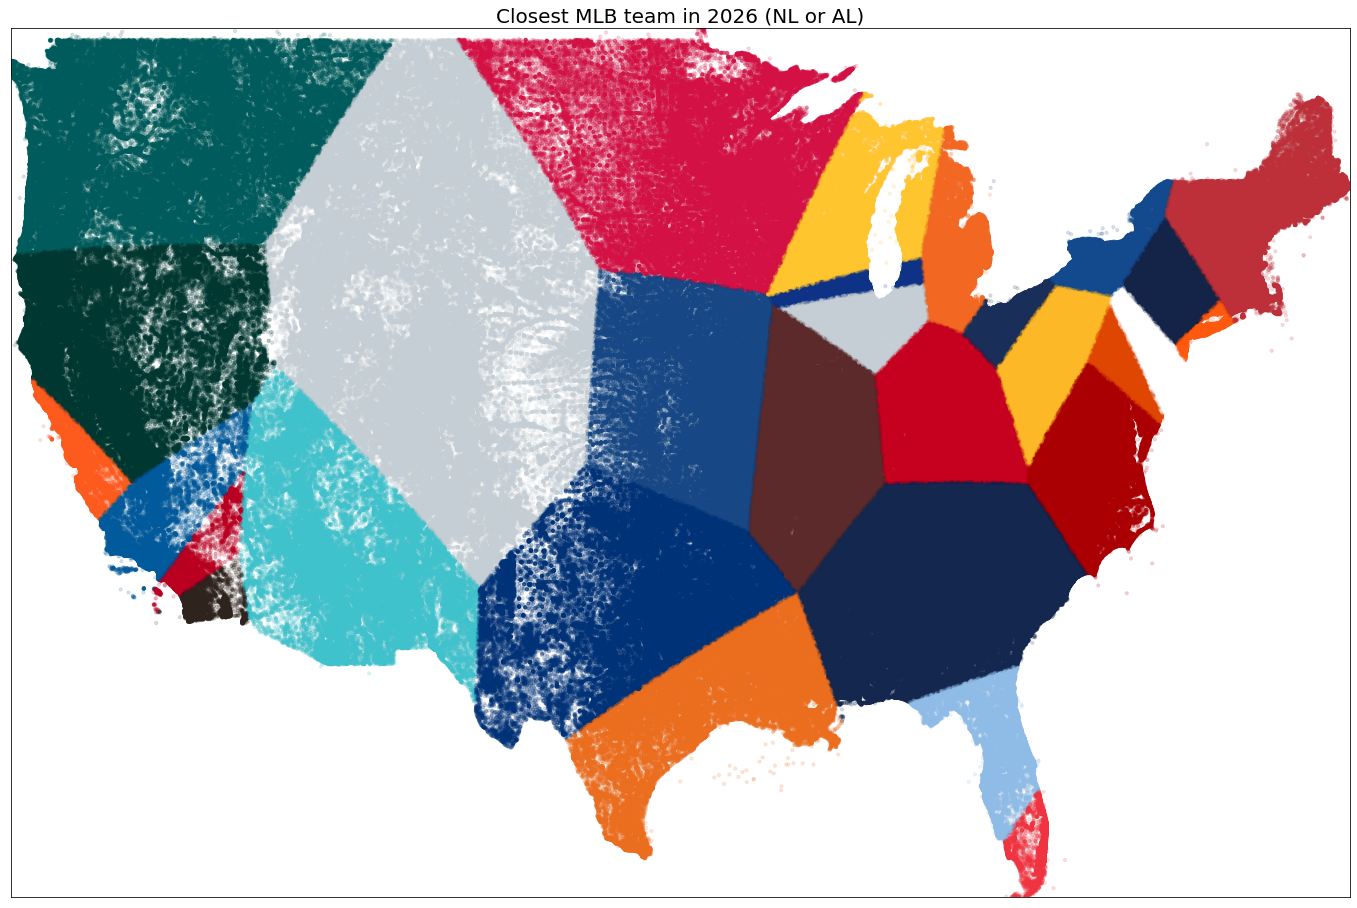

In [18]:
# Iterative style; stripes are manual
for yr in [2026]:
    timer_start = dt.now()
    
    stadia_this_year = [i for i in stadia_alltime if i[4] <= yr and i[5] >= yr]
    print('\n', yr)
    
    # print an alert for changes
    for team in stadia_this_year:
         if yr == team[4]:
            fore_fromhex('New stadium: ' + team[0], team[3])
    
    # get the closest stadium for every geographic point this year        
    closest_team = []
    for index, here in df_points.iterrows():
        min_dist = np.inf
        team_color = ''
        for ls_stadium in stadia_this_year:
            # Meas distances based on pythagorean theorem. There are better ways
#             dist = math.sqrt(
#                 (here[1] - ls_stadium[2])**2
#                 + (here[0] - ls_stadium[1])**2
#                 # lon^2 + lat^2
#             )
            # Haversine great circle distance
            dist = haversine_distance(
                here[0]
                , ls_stadium[1]                
                , here[1]
                , ls_stadium[2]
            )
            if dist < min_dist:
                min_dist = dist
                team_color = ls_stadium[3] # color for now instead
        closest_team.append(team_color)
    
    df_points['closest_team'] = closest_team
    
    for i in stripes:
        if yr >= i[0] and yr <= i[1]:
            print('Stripes')
            i_stripes = df_points[df_points['closest_team'] == i[2]]
            
            # Remove diagonal swathes from whole eligible area
            i_stripes = i_stripes[
                round(i_stripes['latitude'] + i_stripes['longitude'], 0)
                % 2
                == 0
            ]
            
            i_stripes['closest_team'] = i[3]
            df_points.update(i_stripes)     
    
    # Show a full map
    fig, axs = plt.subplots(figsize = (24, 16))
    axs.scatter(df_points['longitude']
               , df_points['latitude']
               , zorder = 1
               , alpha = 0.15
               , c = df_points['closest_team'] # could map to color if 'closest_team' generalized
               , s = 10
              )
                
    axs.set_xlim(BBox[0], BBox[1])
    axs.set_ylim(BBox[2], BBox[3])
    axs.set_yscale('linear')
    axs.set_facecolor = '#EEEEEE'
    
    # TODO: fix
    #     # Add dots for stadiums
    #     plt.scatter(
    #           stadia_this_year[:][2] # west
    #         , stadia_this_year[:][1] # north
    #         , zorder = 1
    #         , alpha = 1
    #         , c = 'black'
    #         , s = 10
    #     )

    plt.xticks([])
    plt.yticks([])
    
    for start, end in yr_to_league.keys():
        if start <= yr <= end:
            leagues = yr_to_league[(start, end)]
            print(leagues)
    
    plt.title(
        f'Closest MLB team in {str(yr)} ({leagues})'
        , fontdict = {'fontsize' : 20}
    )
    

    # plt.show()
    
    # REALLY not getting why this isn't different from the next year's closest team
    old_closest = df_points['closest_team']
    
    plt.savefig(
        os.path.join(output_path, str(yr) + ' MLB cities full map.png')
        , transparent = True
    )
    
    print(dt.now() - timer_start)
    del timer_start

In [45]:
# NYC bounding box
BBox = (-74.5,-73.5
        , 40.2, 41.2)

# Remove points outside the BBox.  Not going to see them anyways
df_points = us_coords[['latitude', 'longitude']].sample(frac = 1, random_state = 1)
df_points = df_points[
    (df_points['longitude'] >= BBox[0])
    & (df_points['longitude'] <= BBox[1])
    & (df_points['latitude'] >= BBox[2])
    & (df_points['latitude'] <= BBox[3])
]


 1938
New stadium: 39°59′46″N 75°9′54″W
New stadium: 30°20′47″N 81°40′30″W
New stadium: 33.774983, -84.365242
New stadium: 40.441944, -79.954167
New stadium: 39.309583, -76.572
New stadium: 39.323889, -76.611111
New stadium: 39°47′17″N 86°11′19″W
New stadium: 38.9175, -77.020278
NL, AL, NNL, or NAL
0:00:09.213834


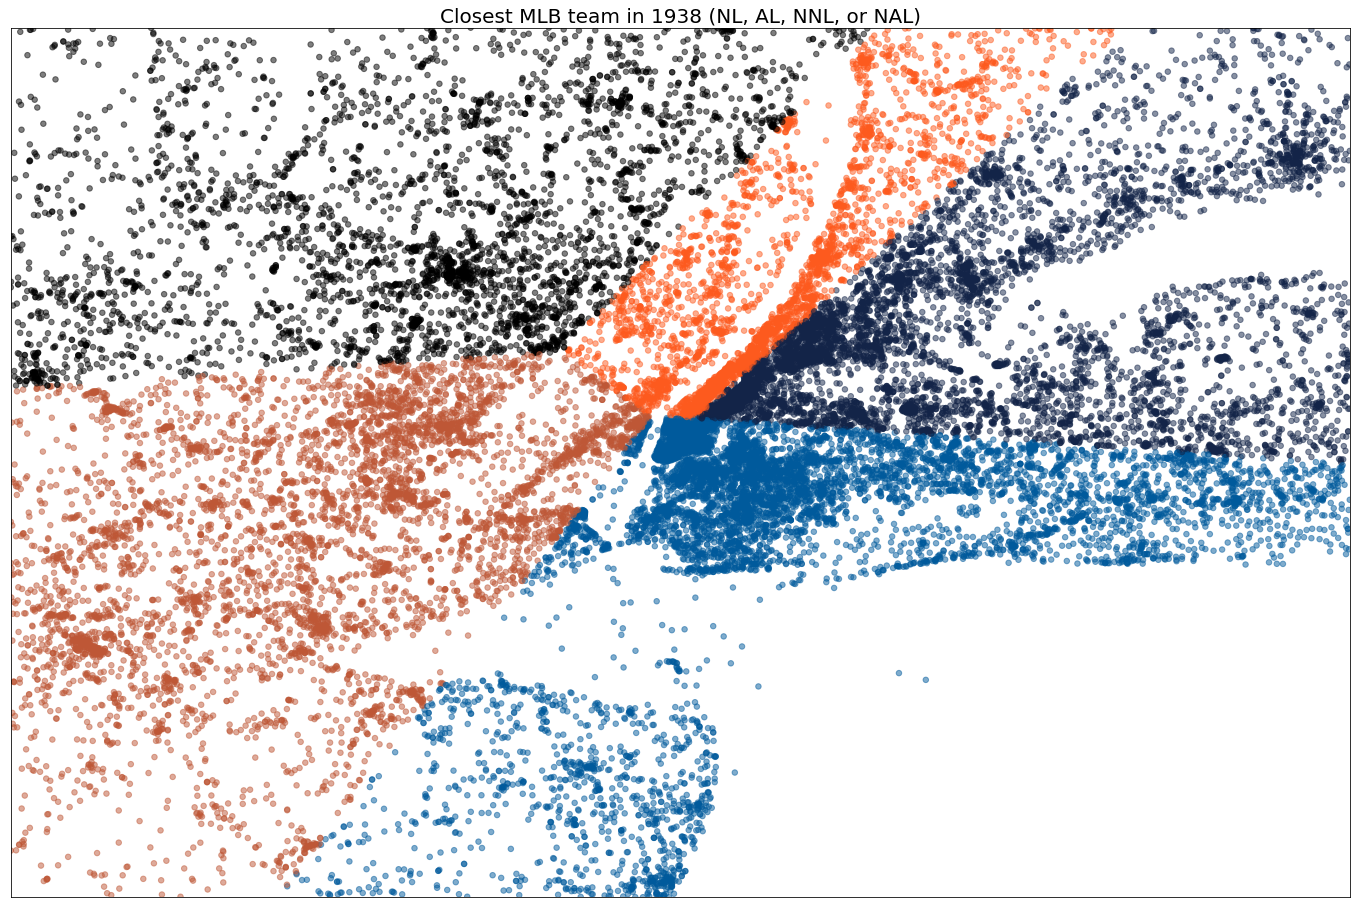

In [48]:
# NYC, iterative, manual stripes
for yr in [1938]:
    timer_start = dt.now()
    
    stadia_this_year = [i for i in stadia_alltime if i[4] <= yr and i[5] >= yr]
    print('\n', yr)
    
    # print an alert for changes
    for team in stadia_this_year:
         if yr == team[4]:
            fore_fromhex('New stadium: ' + team[0], team[3])
    
    # get the closest stadium for every geographic point this year        
    closest_team = []
    for index, here in df_points.iterrows():
        min_dist = np.inf
        team_color = ''
        for ls_stadium in stadia_this_year:
            # Meas distances based on pythagorean theorem. There are better ways
#             dist = math.sqrt(
#                 (here[1] - ls_stadium[2])**2
#                 + (here[0] - ls_stadium[1])**2
#                 # lon^2 + lat^2
#             )
            # Haversine great circle distance
            dist = haversine_distance(
                here[0]
                , ls_stadium[1]                
                , here[1]
                , ls_stadium[2]
            )
            if dist < min_dist:
                min_dist = dist
                team_color = ls_stadium[3] # color for now instead
        closest_team.append(team_color)
    
    df_points['closest_team'] = closest_team
    
    for i in stripes:
        if yr >= i[0] and yr <= i[1]:
            print('Stripes')
            i_stripes = df_points[df_points['closest_team'] == i[2]]
            
            # Remove diagonal swathes from whole eligible area
            i_stripes = i_stripes[
                round(i_stripes['latitude'] + i_stripes['longitude'], 0)
                % 2
                == 0
            ]
            
            i_stripes['closest_team'] = i[3]
            df_points.update(i_stripes)     
    
    # Show a full map
    fig, axs = plt.subplots(figsize = (24, 16))
    axs.scatter(df_points['longitude']
               , df_points['latitude']
               , zorder = 1
               , alpha = 0.5
               , c = df_points['closest_team'] # could map to color if 'closest_team' generalized
               , s = 30
              )
                
    axs.set_xlim(BBox[0], BBox[1])
    axs.set_ylim(BBox[2], BBox[3])
    axs.set_yscale('linear')
    axs.set_facecolor = '#EEEEEE'
    
    # TODO: fix
    #     # Add dots for stadiums
    #     plt.scatter(
    #           stadia_this_year[:][2] # west
    #         , stadia_this_year[:][1] # north
    #         , zorder = 1
    #         , alpha = 1
    #         , c = 'black'
    #         , s = 10
    #     )

    plt.xticks([])
    plt.yticks([])
    
    for start, end in yr_to_league.keys():
        if start <= yr <= end:
            leagues = yr_to_league[(start, end)]
            print(leagues)
    
    plt.title(
        f'Closest MLB team in {str(yr)} ({leagues})'
        , fontdict = {'fontsize' : 20}
    )
    

    # plt.show()
    
    # REALLY not getting why this isn't different from the next year's closest team
    old_closest = df_points['closest_team']
    
    plt.savefig(
        os.path.join(output_path, str(yr) + ' MLB NYC map.png')
        , transparent = True
    )
    
    print(dt.now() - timer_start)
    del timer_start

<Figure size 432x288 with 0 Axes>

In [24]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}\\*.PNG")]
    frame_one = frames[0]
    frame_one.save(
          "Closest Major League Baseball City.gif"
        , format = "GIF"
        , append_images=frames
        , save_all=True
        , duration=588 # 1 minute runtime for 102 frames
        , loop=0
    )

In [54]:
make_gif("C:\\Users\\Admin\\Desktop\\MLB gif")

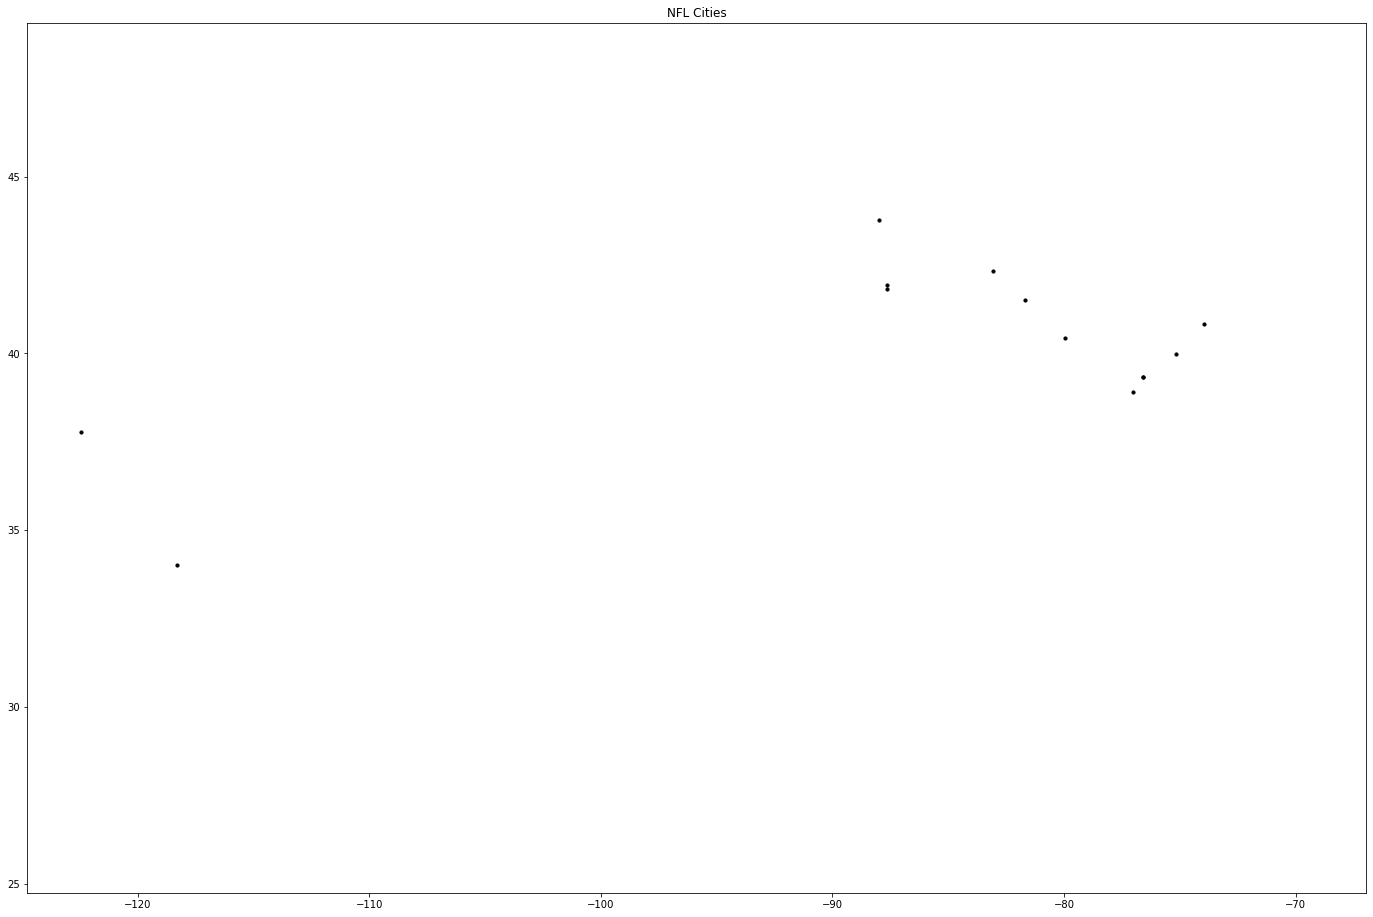

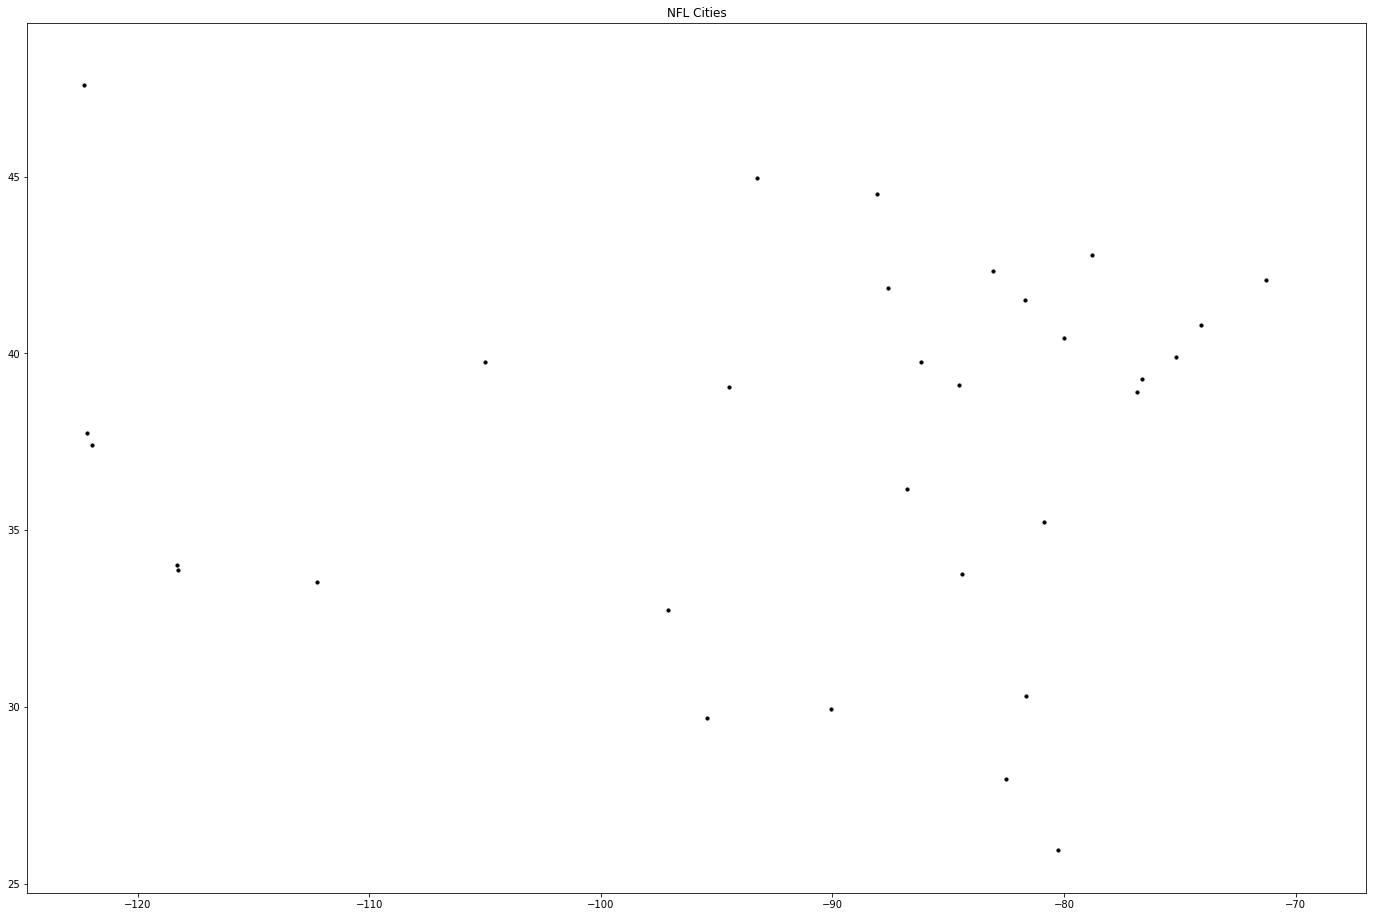

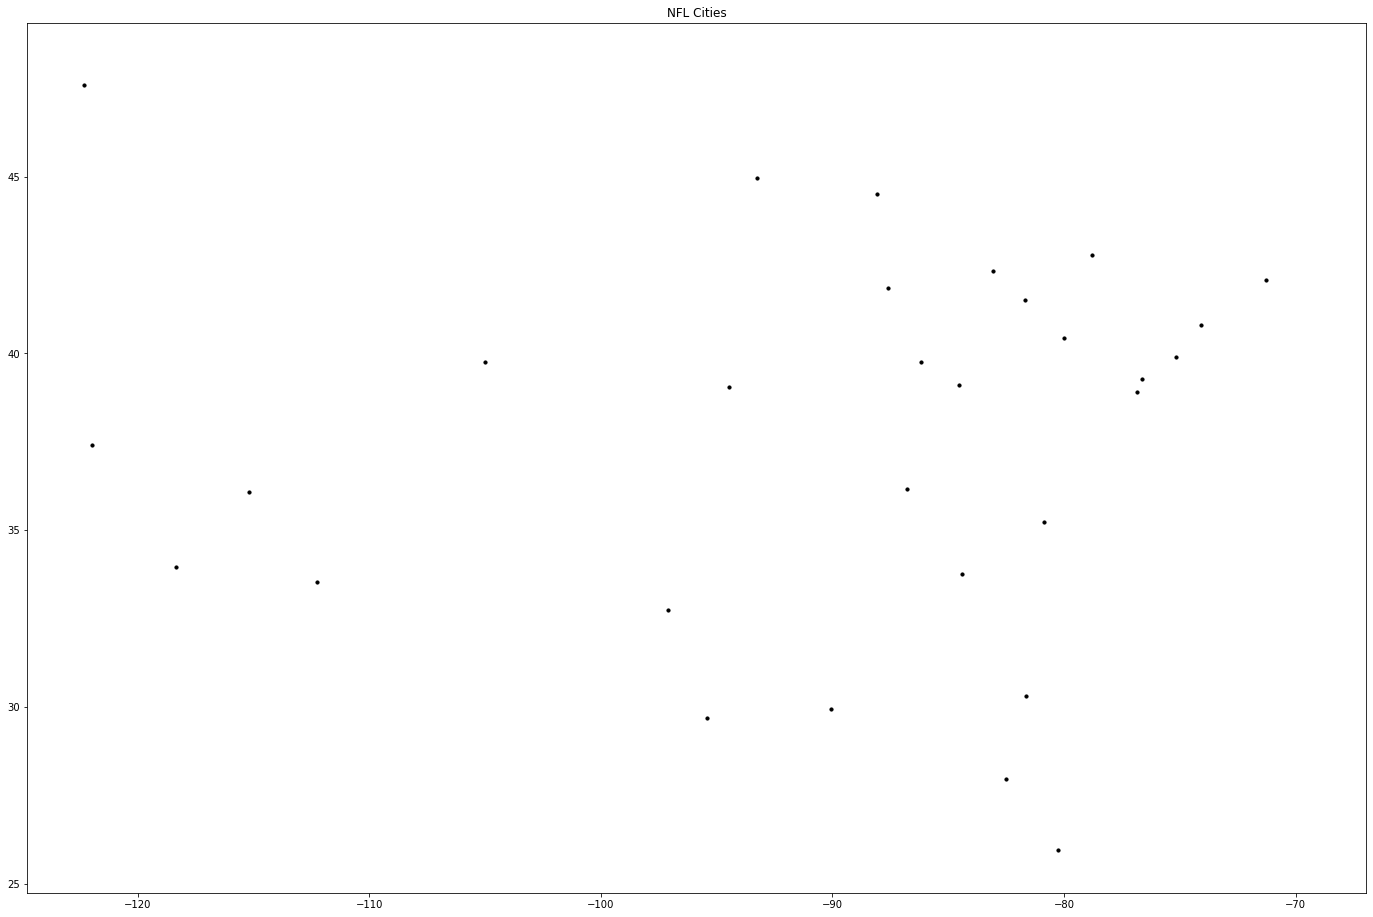

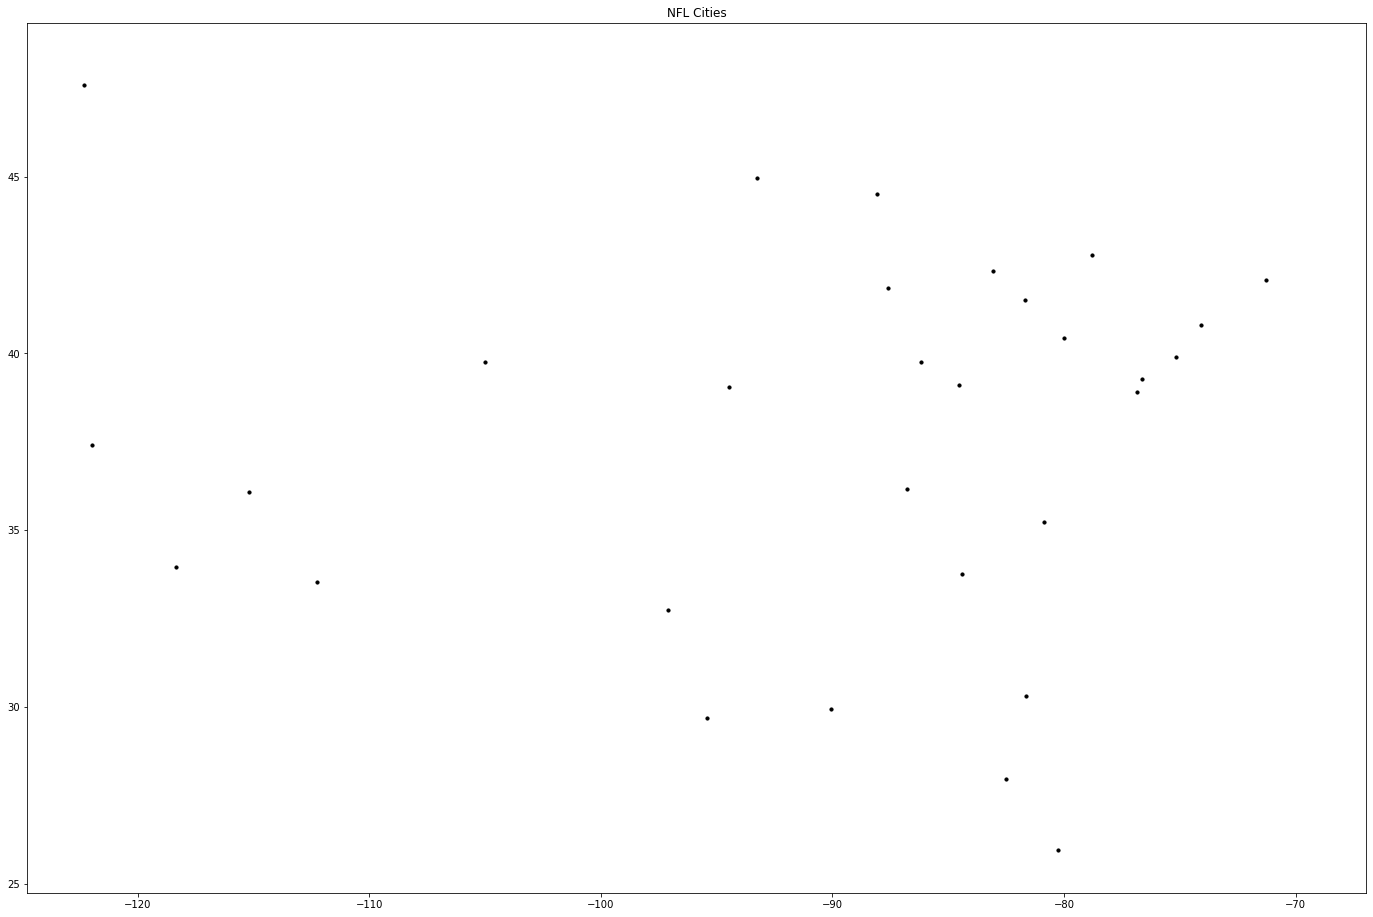

In [18]:
# TODO: Integrate with this visibile on top of full color map

# Plot layer with just points for stadium location
#for yr in range(1920, 2021, 10):
for yr in [1955, 2019, 2020, 2021]:
    stadia_this_year = pd.DataFrame(
        [i for i in stadia_alltime if i[4] <= yr and i[5] >= yr]
    )
    
    fig, axs = plt.subplots(figsize = (24, 16))
    plt.scatter(stadia_this_year[:][2] # west
                   , stadia_this_year[:][1] # north
                   , zorder = 1
                   , alpha = 1
                   , c = 'black'
                   , s = 10
               )

    axs.set_title('NFL Cities')
    axs.set_xlim(BBox[0], BBox[1])
    axs.set_ylim(BBox[2], BBox[3])
    axs.set_yscale('linear')

    plt.show()